In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

In [25]:
sns.set_style("whitegrid")

DATA_FILE = '/Users/annie_lok_yan_wong/Downloads/european_wholesale_electricity_price_data_hourly/For_merging/final_merged/complete_data_only.csv'
OUTPUT_DIR = '/Users/annie_lok_yan_wong/Downloads/european_wholesale_electricity_price_data_hourly/For_merging/data_aggregation'

df = pd.read_csv(DATA_FILE)

In [26]:
def aggregate_by_country(df):
    agg_functions = {
        # Price features
        'price': ['mean', 'median', 'std', 'min', 'max'],
        # Carbon-free features  
        'carbon_free_pct': ['mean', 'median', 'std', 'min', 'max'],
        # Count
        'timestamp': 'count'
    }
    
    # Add renewable_pct if available
    if 'renewable_pct' in df.columns:
        agg_functions['renewable_pct'] = ['mean', 'std']
    
    # Aggregate
    country_df = df.groupby('zone').agg(agg_functions).reset_index()
    
    # Flatten column names
    country_df.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                          for col in country_df.columns.values]
    
    # Rename for clarity
    country_df = country_df.rename(columns={
        'timestamp_count': 'n_observations',
        'price_mean': 'avg_price',
        'price_std': 'price_volatility',
        'carbon_free_pct_mean': 'avg_carbon_free',
        'carbon_free_pct_std': 'carbon_free_volatility'
    })
    
    # Add derived features
    country_df['price_range'] = country_df['price_max'] - country_df['price_min']
    country_df['price_cv'] = country_df['price_volatility'] / country_df['avg_price']
    country_df['cf_range'] = country_df['carbon_free_pct_max'] - country_df['carbon_free_pct_min']
    
    # Calculate negative price percentage
    neg_price_pct = df[df['price'] < 0].groupby('zone').size() / df.groupby('zone').size() * 100
    country_df['negative_price_pct'] = country_df['zone'].map(neg_price_pct).fillna(0)
    
    # Add country names
    country_map = df.groupby('zone')['country'].first()
    country_df['country'] = country_df['zone'].map(country_map)
    
    return country_df

country_df = aggregate_by_country(df)

In [27]:
country_df.head()

,zone,avg_price,price_median,price_volatility,price_min,price_max,avg_carbon_free,carbon_free_pct_median,carbon_free_volatility,carbon_free_pct_min,carbon_free_pct_max,n_observations,renewable_pct_mean,renewable_pct_std,price_range,price_cv,cf_range,negative_price_pct,country
0,AT,91.639397,90.895,45.291189,-270.42,711.69,85.185899,88.285,11.804502,44.72,99.82,17544,80.469048,13.386743,982.11,0.494233,55.10,1.909485,Austria
1,BE,83.777638,85.770,46.476229,-140.00,565.46,75.286626,78.825,11.675843,35.47,94.93,17544,34.283109,14.049253,705.46,0.554757,59.46,3.562472,Belgium
2,CZ,92.937053,93.010,48.607121,-138.75,844.63,54.628689,53.780,10.149919,32.91,85.53,17544,17.491439,9.165953,983.38,0.523011,52.62,2.559280,Czechia
3,DE,86.441628,88.085,48.546017,-316.40,808.87,64.449829,65.965,14.537197,22.70,91.46,17544,59.881969,15.678677,1125.27,0.561605,68.76,3.305974,Germany
4,DK,77.673002,78.575,49.946503,-299.00,936.29,86.918182,88.790,8.026001,36.84,98.15,17544,79.579289,9.099050,1235.29,0.643036,61.31,3.117875,Denmark


In [28]:
print(f"Number of countries: {len(country_df)}")
print(f"Data shape: {country_df.shape}")
print(country_df[['zone', 'avg_carbon_free', 'avg_price']].head())

Number of countries: 17
Data shape: (17, 19)
  zone  avg_carbon_free  avg_price
0   AT        85.185899  91.639397
1   BE        75.286626  83.777638
2   CZ        54.628689  92.937053
3   DE        64.449829  86.441628
4   DK        86.918182  77.673002


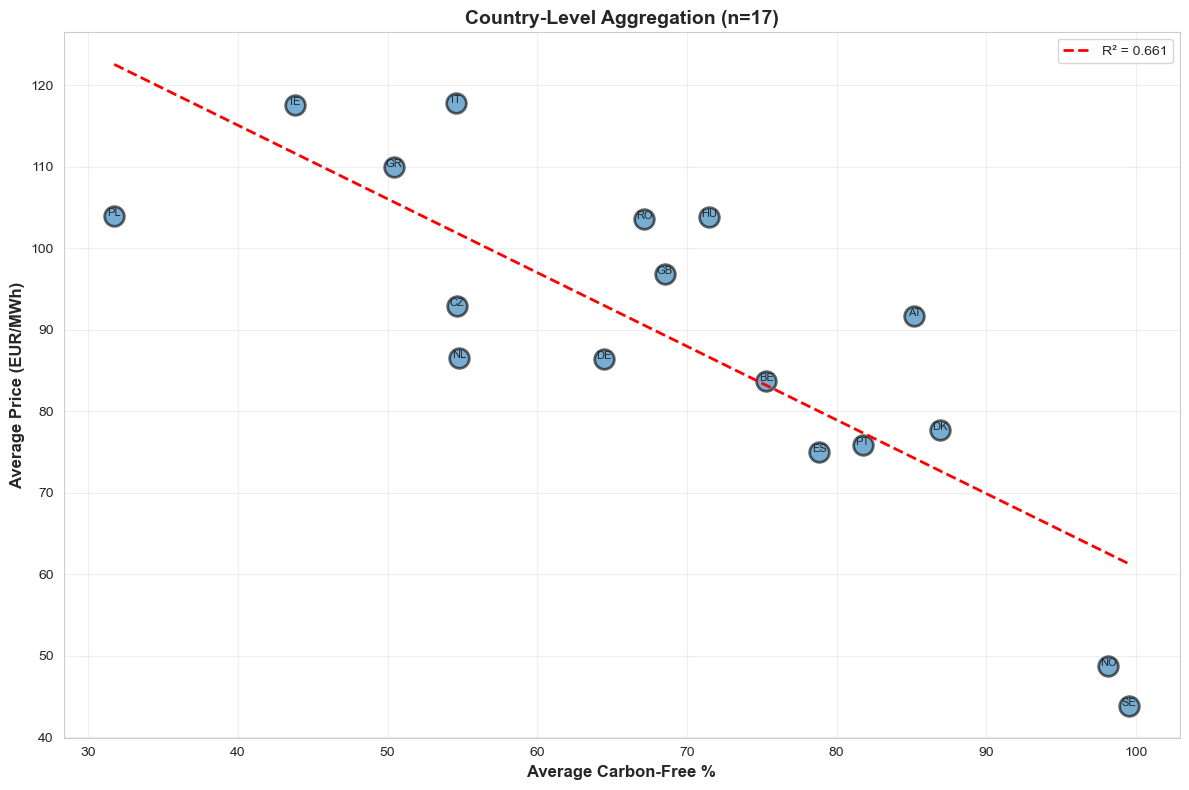

In [29]:
def visualize_aggregations(country_df):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Country-level scatter
    ax1.scatter(country_df['avg_carbon_free'], country_df['avg_price'], 
                s=200, alpha=0.6, edgecolors='black', linewidth=2)
    
    # Add country labels
    for _, row in country_df.iterrows():
        ax1.annotate(row['zone'], 
                     (row['avg_carbon_free'], row['avg_price']),
                     fontsize=8, ha='center')
    
    # Fit regression
    X = country_df[['avg_carbon_free']].values
    y = country_df['avg_price'].values
    model = LinearRegression().fit(X, y)
    
    # Create line
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = model.predict(x_line.reshape(-1, 1))
    
    # Plot line
    ax1.plot(x_line, y_line, 'r--', linewidth=2, 
             label=f'R² = {model.score(X, y):.3f}')
    
    ax1.legend()
    ax1.set_xlabel('Average Carbon-Free %', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Average Price (EUR/MWh)', fontweight='bold', fontsize=12)
    ax1.set_title(f'Country-Level Aggregation (n={len(country_df)})', 
                  fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show() 

visualize_aggregations(country_df)

In [30]:
features = ['avg_price', 'price_volatility', 'avg_carbon_free', 
            'carbon_free_volatility', 'renewable_pct_mean', 'negative_price_pct']

X = country_df[features].values
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
country_df['cluster'] = kmeans.fit_predict(X_scaled)

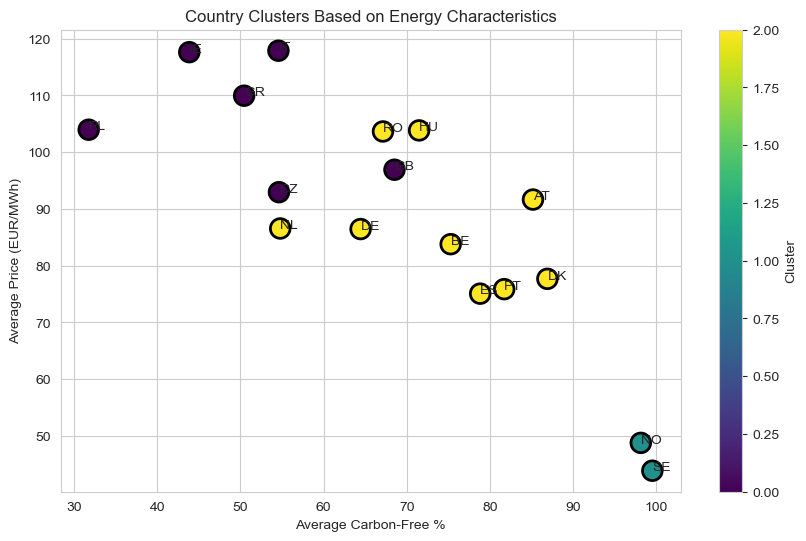

In [31]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(country_df['avg_carbon_free'], country_df['avg_price'], 
                     c=country_df['cluster'], cmap='viridis', s=200, 
                     edgecolors='black', linewidth=2)
for _, row in country_df.iterrows():
    plt.annotate(row['zone'], (row['avg_carbon_free'], row['avg_price']))
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Average Carbon-Free %')
plt.ylabel('Average Price (EUR/MWh)')
plt.title('Country Clusters Based on Energy Characteristics')
plt.show()

In [37]:
features = ['avg_price', 'price_volatility', 'avg_carbon_free', 
            'carbon_free_volatility', 'renewable_pct_mean', 
            'negative_price_pct', 'price_cv', 'cf_range']

X = country_df[features].values
zone_labels = country_df['zone'].values

# Step 1: Standardize features (crucial!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [38]:
print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"PCA dimensions: {X_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

Original dimensions: 8
PCA dimensions: 4
Variance explained: 95.75%


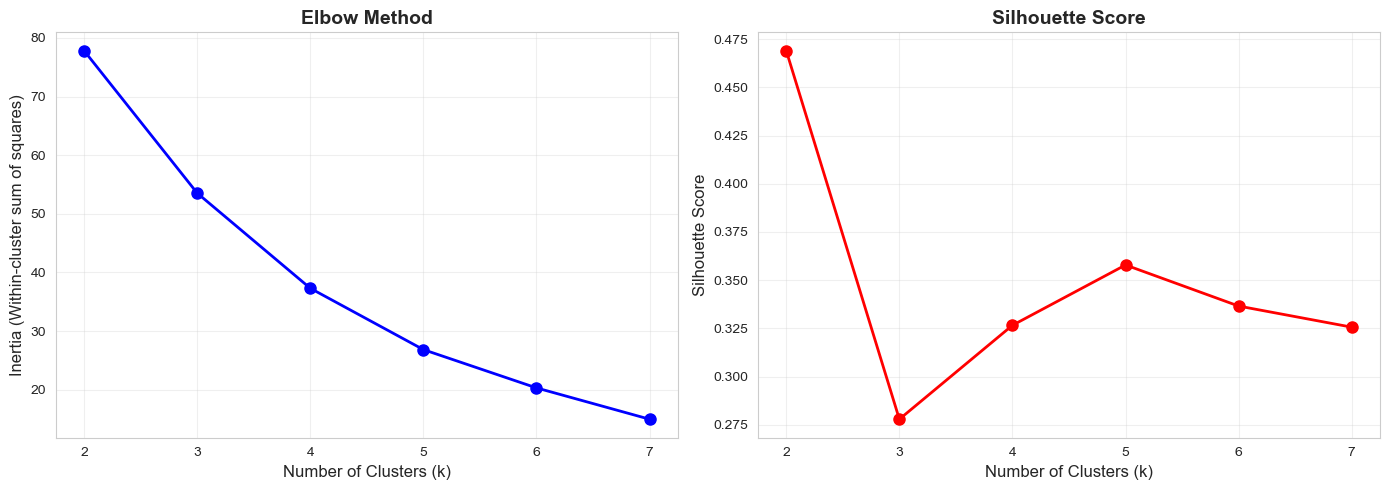

In [42]:
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/xs/rltwwntj3gl2rcygzw0mbmch0000gn/T/ipykernel_79462/1816446249.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


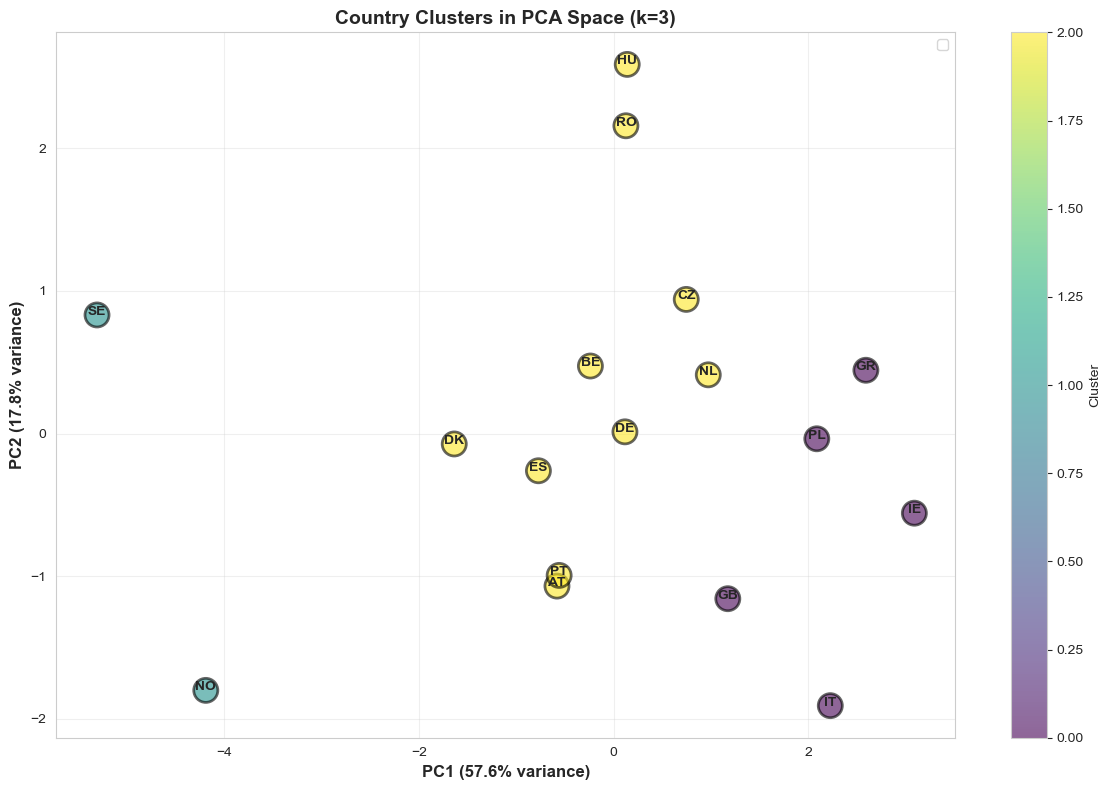

In [43]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

country_df['cluster'] = clusters

plt.figure(figsize=(12, 8))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters, cmap='viridis', s=300, 
                     alpha=0.6, edgecolors='black', linewidth=2)

for i, zone in enumerate(zone_labels):
    plt.annotate(zone, (X_pca[i, 0], X_pca[i, 1]), 
                fontsize=10, ha='center', fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
          fontsize=12, fontweight='bold')
plt.title(f'Country Clusters in PCA Space (k={optimal_k})', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS")
print("="*60)

for cluster_id in range(optimal_k):
    cluster_countries = country_df[country_df['cluster'] == cluster_id]
    print(f"\n📊 CLUSTER {cluster_id} (n={len(cluster_countries)})")
    print(f"Countries: {', '.join(cluster_countries['zone'].values)}")
    print("\nAverage characteristics:")
    
    for feature in features:
        mean_val = cluster_countries[feature].mean()
        print(f"  • {feature}: {mean_val:.2f}")

# Step 7: Feature importance (what drives the clusters?)
print("\n" + "="*60)
print("="*60)

for i in range(min(3, X_pca.shape[1])):  # First 3 PCs
    print(f"\n🔍 PC{i+1} (explains {pca.explained_variance_ratio_[i]:.1%} variance):")
    loadings = pca.components_[i]
    feature_importance = pd.DataFrame({
        'feature': features,
        'loading': loadings,
        'abs_loading': np.abs(loadings)
    }).sort_values('abs_loading', ascending=False)
    
    for _, row in feature_importance.head(3).iterrows():
        direction = "↑" if row['loading'] > 0 else "↓"
        print(f"  {direction} {row['feature']}: {row['loading']:.3f}")



CLUSTER CHARACTERISTICS

📊 CLUSTER 0 (n=5)
Countries: GB, GR, IE, IT, PL

Average characteristics:
  • avg_price: 109.25
  • price_volatility: 45.08
  • avg_carbon_free: 49.82
  • carbon_free_volatility: 15.87
  • renewable_pct_mean: 43.41
  • negative_price_pct: 0.67
  • price_cv: 0.41
  • cf_range: 75.68

📊 CLUSTER 1 (n=2)
Countries: NO, SE

Average characteristics:
  • avg_price: 46.32
  • price_volatility: 35.65
  • avg_carbon_free: 98.85
  • carbon_free_volatility: 0.84
  • renewable_pct_mean: 82.98
  • negative_price_pct: 3.56
  • price_cv: 0.78
  • cf_range: 6.30

📊 CLUSTER 2 (n=10)
Countries: AT, BE, CZ, DE, DK, ES, HU, NL, PT, RO

Average characteristics:
  • avg_price: 87.74
  • price_volatility: 51.77
  • avg_carbon_free: 72.04
  • carbon_free_volatility: 11.60
  • renewable_pct_mean: 52.65
  • negative_price_pct: 2.40
  • price_cv: 0.59
  • cf_range: 59.20


🔍 PC1 (explains 57.6% variance):
  ↑ avg_price: 0.438
  ↓ avg_carbon_free: -0.420
  ↑ cf_range: 0.401

🔍 PC2 (explai